<a href="https://colab.research.google.com/github/Visheshs3/issat_project/blob/main/issatProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ISSAT PROJECT**

In [2]:
# Install the Earth Engine API and authenticate
!pip install earthengine-api
!earthengine authenticate

E0000 00:00:1746298528.439819    1530 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746298528.451195    1530 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Authenticate: Limited support in Colab. Use ee.Authenticate() or --auth_mode=notebook instead.
W0503 18:55:37.410091 135086417399808 _default.py:711] No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20h

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import ee
import pandas as pd
import numpy as np
from datetime import datetime
import folium
import geemap
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import os
!pip install rasterio
import rasterio
from rasterio.merge import merge
import geopandas as gpd
from google.colab import drive


# Initialize the Earth Engine API
ee.Initialize()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 29.9 MB/s eta 0:00:00


**Visualizing AOI**

In [5]:
Map = geemap.Map(center=[12.2958, 76.6394], zoom=10)

# Define center and ROI
mysoreCenter = ee.Geometry.Point([76.6394, 12.2958])
aoi = mysoreCenter.buffer(30000)

# Add to the map
Map.addLayer(mysoreCenter, {'color': 'red'}, 'Mysore Center')
Map.addLayer(aoi, {'color': 'blue'}, '30 km AOI')
Map

Map(center=[12.2958, 76.6394], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

# **Load Satellite Data**

In [6]:
# Define Landsat scaling factor
def apply_scale_factors(image):
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    image = image.addBands(optical_bands, None, True)
    image = image.addBands(thermal_bands, None, True)
    return image

In [7]:
#removing excess cloud

def maskL8sr(image):
    # Bits 3 and 4 are cloud and cloud shadow, respectively.
    qa = image.select('QA_PIXEL')
    cloud_bit_mask = (1 << 3)  # Cloud
    cloud_shadow_bit_mask = (1 << 4)  # Cloud shadow

    # Both flags should be set to zero (i.e., no cloud and no shadow).
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(
           qa.bitwiseAnd(cloud_shadow_bit_mask).eq(0))

    return image.updateMask(mask)

In [8]:

startDate = '2014-10-01'
endDate = '2014-12-31'
# Load Landsat-8 Data
landsat = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterBounds(aoi) \
    .filterDate(startDate, endDate) \
    .filter(ee.Filter.lt('CLOUD_COVER', 20)) \
    .map(apply_scale_factors) \
    .map(maskL8sr) \
    .median() \
    .clip(aoi)

In [9]:
Map = geemap.Map(center=[12.2958, 76.6394], zoom=9)
print(landsat.select('SR_B4').reduceRegion(reducer=ee.Reducer.minMax()).getInfo())

Map.addLayer(landsat, {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 0.3}, 'Landsat')
Map

{'SR_B4_max': 0.09139000000000003, 'SR_B4_min': 0.09139000000000003}


Map(center=[12.2958, 76.6394], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

# TASK 3



In [10]:
# NDVI = (NIR - RED) / (NIR + RED)
ndvi = landsat.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI');

# NDBI = (SWIR - NIR) / (SWIR + NIR)
ndbi = landsat.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI');

# MNDWI = (Green - SWIR) / (Green + SWIR)
mndwi = landsat.normalizedDifference(['SR_B3', 'SR_B6']).rename('MNDWI');

In [11]:
#Initialize all as "others" (value = 3)
classified = ndvi.multiply(0).add(3);

# Vegetation = 1
classified = classified.where(ndvi.gt(0.5), 1);

# Urban = 0 (overwrite vegetation if NDBI is high)
classified = classified.where(ndbi.gt(0.0), 0);

# Water = 2
classified = classified.where(mndwi.gt(0.3), 2);


In [12]:
IndexedMap = geemap.Map(center=[12.2958, 76.6394], zoom=9)

IndexedMap.add_layer(classified, {'min': 0, 'max': 3, 'palette': ['red', 'green', 'blue', 'gray']}, 'Index-based Classification')

IndexedMap

Map(center=[12.2958, 76.6394], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

In [13]:
import math

# Function to create a sector polygon from angle and radius
def create_sector(center, start_angle, angle_width, radius):
    coords = []

    # Convert angles to radians
    start = math.radians(start_angle)
    end = math.radians(start_angle + angle_width)

    # Number of points to draw the arc
    steps = 30
    for i in range(steps + 1):
        angle = start + (end - start) * i / steps
        x = center.coordinates().get(0).getInfo() + radius * math.cos(angle) / 111320
        y = center.coordinates().get(1).getInfo() + radius * math.sin(angle) / 110540
        coords.append([x, y])

    # Close the sector back to center
    coords.insert(0, center.coordinates().getInfo())
    coords.append(center.coordinates().getInfo())

    return ee.Feature(ee.Geometry.Polygon([coords]))

# Create 8 sectors (45 degrees each)
sectors = ee.FeatureCollection([
    create_sector(mysoreCenter, i * 45, 45, 30000)
    for i in range(8)
])

In [14]:
SectoredMap=geemap.Map(center=[12.2958, 76.6394], zoom=9)
SectoredMap.add_layer(sectors, {}, '45° Sectors')
SectoredMap

#Map.add_layer(sectors, {}, '45° Sectors')

Map(center=[12.2958, 76.6394], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

In [15]:
# Create binary masks
urban = classified.eq(0).rename('urban')
veg = classified.eq(1).rename('vegetation')
water = classified.eq(2).rename('water')
others = classified.eq(3).rename('others')

# Combine into multi-band image
classes = ee.Image.cat([urban, veg, water, others])

# Multiply by pixel area (hectares)
area_image = classes.multiply(ee.Image.pixelArea().divide(10000))

# Now reduce per sector
sector_stats = area_image.reduceRegions(
    collection=sectors,
    reducer=ee.Reducer.sum().repeat(4),  # because 4 bands
    scale=30,
    tileScale=4
)

for f in sector_stats.getInfo()['features']:
    print(f"Sector:")
    print(f"Urban : {f['properties']['sum'][0]:.2f} hectare")
    print(f"Vegetaion : {f['properties']['sum'][1]:.2f} hectare")
    print(f"Water : {f['properties']['sum'][2]:.2f} hectare")
    print(f"Others : {f['properties']['sum'][3]:.2f} hectare")
    print()

Sector:
Urban : 2090.05 hectare
Vegetaion : 29314.16 hectare
Water : 381.94 hectare
Others : 2767.38 hectare

Sector:
Urban : 3973.07 hectare
Vegetaion : 27034.03 hectare
Water : 158.67 hectare
Others : 2968.55 hectare

Sector:
Urban : 3580.91 hectare
Vegetaion : 19938.97 hectare
Water : 5791.19 hectare
Others : 4784.78 hectare

Sector:
Urban : 2452.11 hectare
Vegetaion : 26222.87 hectare
Water : 2860.52 hectare
Others : 3017.94 hectare

Sector:
Urban : 2604.59 hectare
Vegetaion : 28606.74 hectare
Water : 46.64 hectare
Others : 3307.17 hectare

Sector:
Urban : 2484.09 hectare
Vegetaion : 28914.71 hectare
Water : 242.24 hectare
Others : 2508.02 hectare

Sector:
Urban : 3485.14 hectare
Vegetaion : 26544.47 hectare
Water : 234.00 hectare
Others : 3855.63 hectare

Sector:
Urban : 1760.29 hectare
Vegetaion : 29184.23 hectare
Water : 491.06 hectare
Others : 3129.65 hectare



#Calculating LST using Mono Window Algorithm

**Satellite data used is LANDSAT/LC08/C02/T1**

which has raw reflectance data to apply Mono Window Algorithm

# Mono Window Algorithm

In [16]:
def calc_radiance(img, band, mult_key, add_key):
    return img.select(band) \
        .multiply(ee.Number(img.get(mult_key))) \
        .add(ee.Number(img.get(add_key)))

def apply_mono_window(img):
    k1 = ee.Number(img.get('K1_CONSTANT_BAND_10'))
    k2 = ee.Number(img.get('K2_CONSTANT_BAND_10')) # thermalconstants of image

    var_radiance = calc_radiance(img, 'B10', 'RADIANCE_MULT_BAND_10','RADIANCE_ADD_BAND_10') # radiance for B10
    # calculating ndvi
    ref4 = calc_radiance(img, 'B4', 'REFLECTANCE_MULT_BAND_4', 'REFLECTANCE_ADD_BAND_4')
    ref5 = calc_radiance(img, 'B5', 'REFLECTANCE_MULT_BAND_5', 'REFLECTANCE_ADD_BAND_5')
    ndvi = ref5.subtract(ref4).divide(ref5.add(ref4)).rename('NDVI')
    bt = var_radiance.expression(            # calculating bt(brightness temp)
        '(k2 / log(k1 / L + 1)) - 273.15', {
          'k1': k1,
          'k2': k2,
          'L': var_radiance
    }).rename('BT')

    # Calculate PV and Emissivity
    pv = ndvi.subtract(-1).divide(2)
    pv = pv.pow(2).rename('PV')
    emissivity = pv.multiply(0.004).add(0.986).rename('Emissivity')

    # Calculate LST
    lst = bt.divide(
      ee.Image(1).add(
        bt.multiply(10.4e-6).divide(1.438e-2).multiply(emissivity.log())
      )
    ).rename('LST')

    return img.addBands(lst, None, True)



# Map

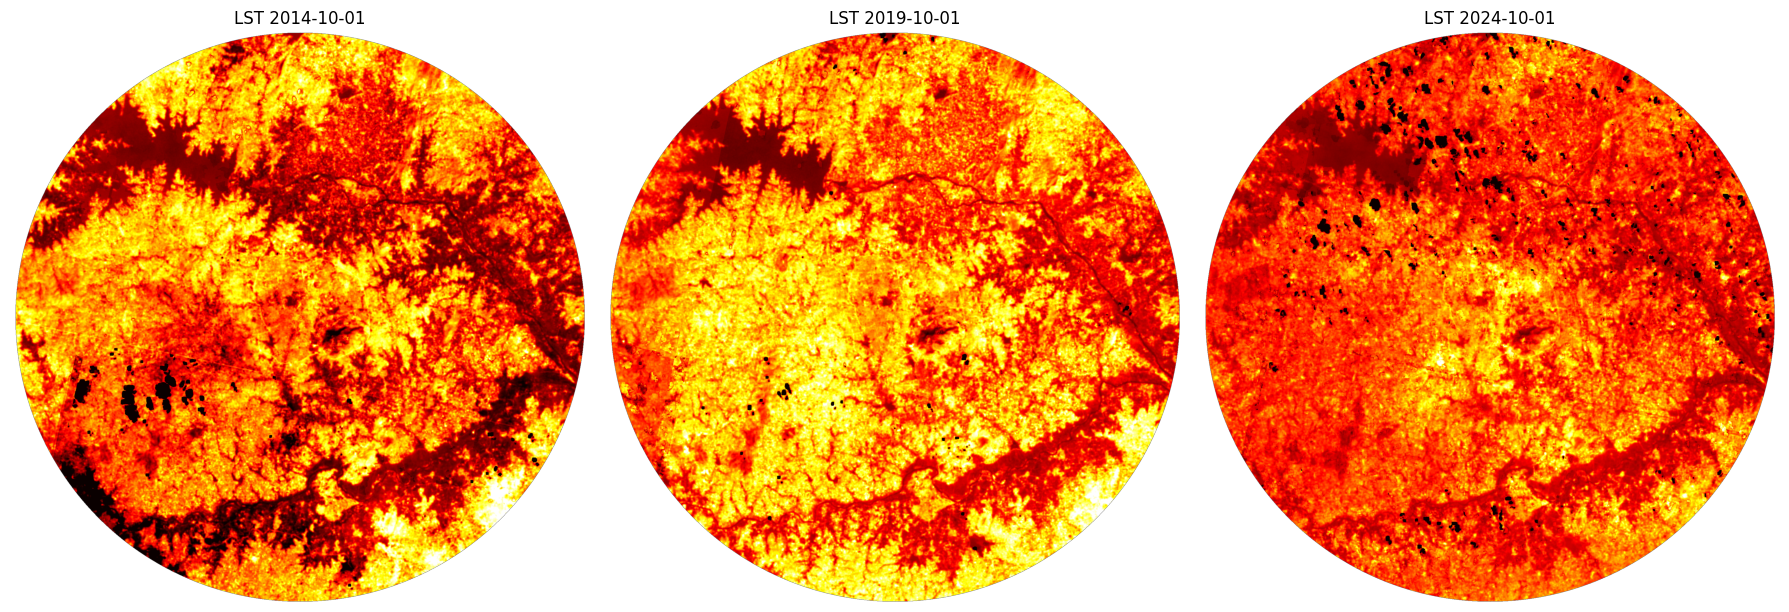

In [17]:
# Add layers to the map

LSTMap= geemap.Map()
LSTMap.centerObject(mysoreCenter, 10)
LSTMap.addLayer(mysoreCenter, {'color': 'red'}, 'Mysore Center')

data = [['2014-10-01', '2014-12-31', 'LANDSAT/LC08/C02/T1'],
        ['2019-10-01', '2019-12-31', 'LANDSAT/LC08/C02/T1'],
        ['2024-10-01', '2024-12-31', 'LANDSAT/LC08/C02/T1']]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (start, end, collection) in enumerate(data):
  image = (ee.ImageCollection(collection)
             .filterBounds(aoi)
             .filterDate(start, end)
             .filter(ee.Filter.lt('CLOUD_COVER', 20))
             .map(apply_mono_window)
             .map(maskL8sr)
             .median()
             .clip(aoi))

  # Add layers to map
  arr = geemap.ee_to_numpy(image.select('LST'), region=aoi, scale=30)
  arr = np.squeeze(arr)

  # Generate true circular mask for 30 km radius
  h, w = arr.shape
  y, x = np.ogrid[:h, :w]
  center_y, center_x = h // 2, w // 2
  pixels_radius = int(30000 / 30)  # 30 km in pixels
  circular_mask = (x - center_x)**2 + (y - center_y)**2 <= pixels_radius**2
  arr[~circular_mask] = np.nan  # Mask outside circle

  axes[i].imshow(arr, cmap='hot', vmin=20, vmax=30)
  axes[i].set_title(f"LST {start}")
  axes[i].axis('off')

plt.tight_layout()
plt.show()


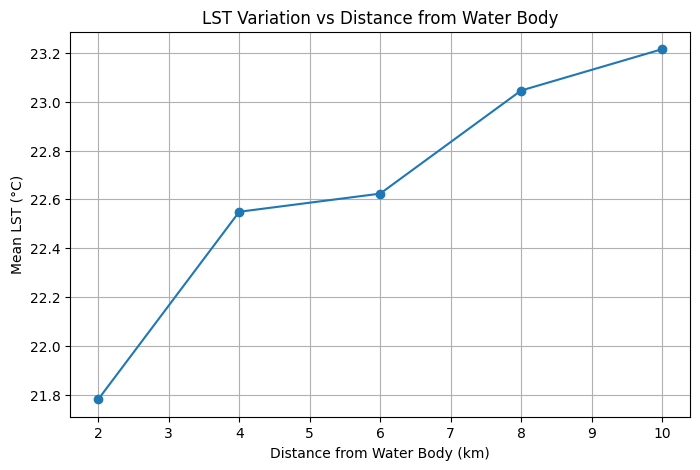

In [45]:
water_point = ee.Geometry.Point([76.567, 12.437])

# Distances (in meters) for concentric rings: 2km to 10km
distances = [2000, 4000, 6000, 8000, 10000]

# Create concentric rings
rings = []
for d in distances:
    outer = water_point.buffer(d)
    inner = water_point.buffer(d - 2000) if d > 2000 else water_point
    rings.append(outer.difference(inner))

# Load and preprocess Landsat LST image
collection = ee.ImageCollection("LANDSAT/LC08/C02/T1") \
    .filterBounds(water_point) \
    .filterDate("2024-10-01", "2024-12-31") \
    .filter(ee.Filter.lt('CLOUD_COVER', 20)) \
    .map(apply_mono_window)  # apply_mono_window should return an image with LST band

lst_image = collection.median().select("LST")

# Get mean LST for each ring
mean_lst = [
    lst_image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=ring,
        scale=30,
        maxPixels=1e9
    ).getInfo()["LST"] for ring in rings
]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot([2, 4, 6, 8, 10], mean_lst, marker='o')
plt.title("LST Variation vs Distance from Water Body")
plt.xlabel("Distance from Water Body (km)")
plt.ylabel("Mean LST (°C)")
plt.grid(True)
plt.show()